# Report

## Problem definition
The desired output of the case is an algorithm that is responsible for bidding for the demand load volumes necessary for the optimal charging of an EV fleet of Tibber's customers in Stockholm (delivery area SE3). As final output, this project aims to generate the following parameters of a limit order for each hour of the coming day:
- Size (MW)
- Maximum price (EUR/MW)

To generate this information, the case requires to consider the following questions:
1. What should be the limit (maximum) price of the order?
2. What should be the size (MW) of the order?

The section below describes the methodology that will be carried out to come up with these parameters, in a 3-step process.

### 1. Limit Price
The first step of my assignment addresses the simplified case in which there are two alternatives for sourcing the power needed in hour $H^i$ to charge the EV fleet, buying the power for that hour at: (i) spot price ($P^{da}_i$) at day-ahead auction, or (ii) imbalance price ($P^{imb}_i$) at settlement. To make a reasonable estimation of the price we are willing to pay, it is advisable to consider an estimated expected cost for each given hour.

Let's define the `expected_cost_eur` ($\widehat{cost_i}$) for $H^i$ as: 
$$
\widehat{cost_i} = \widehat{P^{da}_i} + \operatorname{prob}(P^{da}_i < P^{imb}_i) \times \widehat{\text{spread}}_i \times \frac{1}{\tau}
$$

Where $\widehat{P^{da}_i}$ is the day-ahead forecast of the spot price for hour $i$, $\operatorname{prob}(P^{da}_i < P^{imb}_i)$ is the probability of the spot price being smaller than the imbalance price for that hour, $\widehat{\text{spread}}_i$ is the expected gain estimated from buying the power at spot-price as opposed to at settlement ($\widehat{P^{imb}_i - P^{da}_i}$), and $\tau$ is the risk tolerance for our algorithm ($\tau \in (0,1]$). Our risk tolerance parameter allows us to pay a larger premium for decreasing the uncertainty of settling at $P^{imb}$, and is given on a decreasing scale where 1 is very risk tolerant and 0.01 is very risk averse. For the sake of argument, in this assignment I will assume a risk tolerance of 0.7 and is saved with the other constant parameters in `config.yaml` for the program to run at the user's specifications.

In a nutshell, I aim to answer the following questions:

1. What is the probability that the spot price of Hour $H^i$ is less than its imbalance price? 
2. What is the expected premium to be paid if we were to buy $H^i$ in settlement as opposed to in day-ahead auction?

Here, the proposed methodology is as follows:
1. Model the probability that spot is lower than imbalance price by specifying a classifier model.
2. Model the expected premium to be paid in case of making an incorrect decision by specifying a regression model.

Once fitted, these two models will be used in Step 3.

### 2. Size
Regarding the size, the portfolio of EVs has some intrinsic characteristics based on the cars' `arrival_time`, `departure_time`, `initial_soc_perc`, `battery_size_kwh`, and `max_charging_speed_kw`, where these parameters are as described in the case. As suggested, these parameters are randomly generated within reasonable ranges to have as input for the assignment. From this set of characteristics, we can derive the distribution of demand load per hour.

Consider a variable $\text{to\_charge\_kwh}_j$ which is the volume necessary to bring car $j$ from its `initial_soc_perc` to a full charge. This variable is defined as :

$$
\text{to\_charge\_kwh}_j = \text{battery\_size\_kwh}_j \times (1 - \text{initial\_soc\_perc}_j) \times 0.9
$$ 

Where the multiplication by 0.9 corrects for average charging efficiency, as the charging of an EV is not linear and it takes longer to charge in the range 70-100%.

From this variable, we can compute the minimum time needed to charge in minutes (see multiplication by 60 minutes per hour) and assign it to the variable `min_time_needed_minutes`: 

$$
\text{min\_time\_needed\_minutes}_j = \frac{\text{to\_charge\_kw}_j}{\text{max\_charging\_speed\_kw}_j} \times 60 \text{ minutes}
$$

From here, I need to answer the following questions:
1. How much power does the fleet of 1000 EV need to charge overnight?
2. What is the maximum charging capacity for each hour in the overnight charging session?

The proposed methodology consists of the following steps:
1. Generate random values for the individual car's characteristics based on reasonable ranges.
2. Estimate the average demand load ($T$) to charge the fleet of EVs.
3. Simulate the distribution of maximum demand load (charge capacity) per hour based on the portfolio of EVs, as composed of the generated individual cars.


The average demand load and maximum demand load (charge capacity) per hour that come from this section will be used in Step 3.

### 3. Optimizing total costs for Tibber
The primary goal of this project is to build an algorithm that minimizes the total cost of charging a fleet of electric vehicles. Here I can use linear programming optimization to find the most efficient charging schedule.

To do this, we want to minimize the total cost for a given night's charging session, $n$. With this in mind, let's define the total costs that Tibber pays for a given night $n$ as:

$$
\text{Total\_Costs}_n = \sum_{i=1}^{N} v_i \cdot \widehat{\text{cost}_i}
$$ 

Where $i$ is specific hour, $N$ is the total number of hours in the night charging session $n$ (i.e., between the earliest arrival at $H^{17}_{d+1}$ and latest departure at $H^{10}_{d+2}$), $v_i$ is the volume to be charged during hour $i$, and $\widehat{\text{cost}_i}$ is the expected cost for that hour as calculated in Step 1. 

The optimization must adhere to several constraints. The hourly charging volume, $v_i$ cannot exceed the maximum available charging capacity for that hour, $v^{max}_i$, computed in Step 2. We also have a constraint that the total energy charged over the session ($T$) must meet the fleet's required energy demand, so that Tibber's smart charging service can ensure that the customers cars can be charged at optimal costs. Therefore:

$$
0 \leq v_i \leq v^{\text{max}}_i, \quad \sum_{i=1}^{N} v_i = T
$$

 By solving this problem, the algorithm finds the optimal hourly charging volumes that satisfy the total energy demand at the lowest possible cost.

## Data sources
### 1. Limit price
For the two models built in this section, the following features will be considered (with an hourly resolution):
- `spot_fc_eur`: simulated DA spot price forecast for SE3
- `DOW`: day of the week, fixed effects as a dummy variable to control for daily patterns in consumption
- `demand_fc_mwh`: simulated demand load forecast for SE3
- `wind_fc_mwh`: simulated forecast of wind power generation for SE3
- `solar_fc_mwh`: simulated forecast of solar power generation for SE3
- `nuclear_fc_mwh`: simulated forecast of nuclear power generation for SE3
- `hydro_fc_mwh`: simulated forecast of hydro power generation
- `thermal_fc_mwh`
- `spot_fc_eur`: simulated forecast of the spot price
- `temp_fc_celsius`: simulated forecast of the air temperature (2m) above ground for SE3
- `precipitation_fc_mmh`: simulated forecast of the precipitation to be expected for SE3

Additionally, the historical spread will be computed based on:
- `spot_eur`: realized DA spot prices for SEK3
- `imb_eur`: consumption imbalance settlement price (one-prices system) for SE3 

The spot prices are sourced from https://newtransparency.entsoe.eu and the imbalance prices from https://opendata.esett.com. Unfortunately, I do not have the forecasts available. For the sake of argument, I will simulate the forecasts by taking their recorded value and adding a random error so that they do not (necessarily) match their true values. This simulation of the forecast assumes a good forecast has a mean absolute error close to zero and that the error term is randomly distributed. The power generation/consumption data is sourced from https://opendata.esett.com and the weather data from https://www.renewables.ninja. 

### 2. Size
For the reasonable ranges, I start by defining the `battery_size_kwh` and `max_charging_speed_kw` of the vehicles, assuming that the car is one of the 5 [most popular EV cars in Sweden](https://www.teslarati.com/tesla-model-y-sweden-registration-2024/) (i.e., TESLA MODEL Y, VOLVO EX30, VOLVO EX/XC40, POLES 2, or VW ID.4). The specs of these cars indicate:

| Model                                       |                                                                                                                           Battery capacity (kWh) |                                                                                                                           Max DC fast-charge power (kW) | Source |
| ------------------------------------------- | -----------------------------------------------------------------------------------------------------------------------------------------------: | ------------------------------------------------------------------------------------------------------------------------------------------------------: | ------ |
| Tesla Model Y                               |                                                           **\~75 kWh** (useable \~75 kWh / nominal \~78 kWh for recent Long-Range/Performance packs) |                                                                        Up to **250 kW** (Tesla Supercharger V3/V4 peak for Model Y).  | [EV Database][1]       |
| Volvo EX30                                  |                                                                                                  **69.0 kWh** (battery capacity shown by Volvo). |                                                                            **200 kW** (10–80% listed for DC 200 kW, Volvo spec page).  | [Volvo Cars][2]     |
| Volvo EX/XC40 (XC40 Recharge / EX40 family) |                                                                      **\~82 kWh** nominal (XC40 Recharge / EX40 single-motor / long-range pack). |                                                               **\~200 kW** (XC40/EX40 fast charge peak ≈200 kW on larger pack trims).  | [Volvo Cars][3]       |
| Polestar 2                                  |  **\~70 kWh** (standard-range) | **Up to 180–205 kW** depending on model/year and trim (long-range / newer trims support up to \~205 kW). ( |   [Polestar – Electric cars \| Polestar US][4]     |
| VW ID.4                                     |                                                  Net/nominal packs commonly **\~82 kWh** (larger pack). |                                      **~175 kW** (Pro/larger-battery versions)  | [Volkswagen Newsroom][5]       |

[1]: https://ev-database.org/car/2186/Tesla-Model-Y-Long-Range-RWD?utm_source=chatgpt.com "Tesla Model Y Long Range RWD"
[2]: https://www.volvocars.com/us/cars/ex30-electric/specifications/ "Volvo EX30 Fully Electric SUV | Specifications | Volvo Cars USA"
[3]: https://www.volvocars.com/en-jo/cars/xc40-electric/specifications/?utm_source=chatgpt.com "XC40 Recharge pure electric specifications"
[4]: https://www.polestar.com/uk/polestar-2/specifications/?utm_source=chatgpt.com "Polestar 2 Tech Specs"
[5]: https://www.volkswagen-newsroom.com/en/the-id4-from-volkswagen-15712/technical-data-of-the-id4-15724?utm_source=chatgpt.com "Technical data of the ID.4"

The average `arrival_time`, `departure_time`, `initial_soc_perc` values for each of the cars will be randomly generated, with a normal distribution in line with the law large numbers. For `initial_soc_perc`, I assume that each car will consume between 4 and 90% of its battery daily and that the car will be connected every night by the owner to get some Grid Rewards.

According to [ev-rything.com](https://ev-erything.com/ac-at-home-charging/), the typical AC limits for Swedish home charging stations are 3.7 kW, 7.4 kW, 11 kW, 22 kW. Clearly, this is much below the maximum charging speed of any of the vehicles, so these will be used as binding options for the random assignment of `max_charging_speed_kw`. A reasonable assumption is that if you own an EV, you would invest in charging station with a higher charging speed, for which I make it more likely for the higher speeds when assigning the random `max_charging_speed_kw`. The assumed reasonable ranges are stored in `config.yaml`, so they can easily be modified for the whole program if anything changes.

## Performance Report
This section gives an executive overview of the performance of the different steps conducted.

### Step 1: Limit price
Step 1 started with modelling the probability that the imbalance price would be higher than the spot price, which was specified in an ensemble classifier model (Model 1). As an initial step, I surveyed the correlation between features and targets with a Spearman correlation matrix to capture non-linear correlations. As seen in the figure below, the features do not indicate extremely high multicollinearity that could pollute the estimates. The only two variables that seem to be highly correlated are `spot_eur` and `imb_eur`, which are not used as features but dropped.

![Spearman correlation matrix](src/data/figures/correlation_matrix.png)

From this point on, every performance evaluation is conducted on the testing data set, which is new information to the models and was not used for training.

First, I specified and evaluated Model 1. The table classification table below shows promising results:
- precision of class 1: the model successfully predicts 64% of the cases in which $P^{da} < P^{imb}$.
- recall of class 1: out of all the cases in which $P^{da} < P^{imb}$, the model correctly classified  as positive 91% of them.

![Classification report](src/data/figures/classification_report_ensemble.png)

For model 2, I carried out a similar procedure and generated a few evaluation metrics. As expected, trying to predict the $P^{imb}-P^{da}$ spread only based on data available at day-ahead is a very challenging task. Wheras the Mean Absolute Error (€10.75) does not seem too bad, the very low $R^2$ (0.04) and poor fit visible in the plot below are a testament to the difficulty of this task. However, the F-statistic of 6.57 (p-value<0.001) suggest that the model makes a better prediction than simply taking the average. 

![Regression line plot](src/data/figures/regression_line_plot.png)

### Step 2: Size
This step aims to estimate the distribution of maximum demand load (charge capacity in kW) per hour based on a simulated portfolio of EVs. Based on the simulated characteristics per EV, I estimate the maximum demand load expected by running a 500 Montecarlo simulations. This process generates two outcomes:
- Average demand load of our customer's EV fleet per charging session: ~32 MW, as stored in `.src\total_demand.csv`.
- Average maximum charging capacity per hour: the maximum volume that the smart charging service can use in each hour, as illustrated in the figure below. 

![Max charging capacity per hour](src/data/figures/hourly_charging_load_simulation.png)


### 3. Optimizing total costs for Tibber
The final goal of the assignment is to find a way to supply the EV fleet with its demanded charging volume at the lowest price possible. Luckily, the smart charging service is able to charge the cars when the electricity price is the lowest. The challenge is to optimize the sourcing of power by either buying the volumes at the day-ahead auction or at imbalance (n.b., for now I ignore the Intraday market). This optimization is done by nominating conditional volumes via a limit order in the day-ahead auctions. In the limit order, we enter:
- The maximum price Tibber is willing to pay for hour $i$ ($\widehat{cost_i} = \widehat{P^{da}_i} + prob(P^{da}<P^{imb})_i \times \widehat{\text{spread}}_i$). This step is possible thanks to the models from Step 1.
- The hourly schedule (volumes $v'$) that would make the lowest possible costs while still ensuring that the fleet can be charged (). This step is possible thanks to the models from Step 2.

If the realized spot price is equal or lower than our price limit ($\widehat{cost_i}$), our order for volumes ($v'$) would be filled at day-ahead spot price ($P^{da}$). Alternatively, our order would not be filled and we would settle volumes {$v'$} at imbalance price ($P^{imb}$).

Let's backtest the performance of the algorithm:

Final PnL: €16352.94


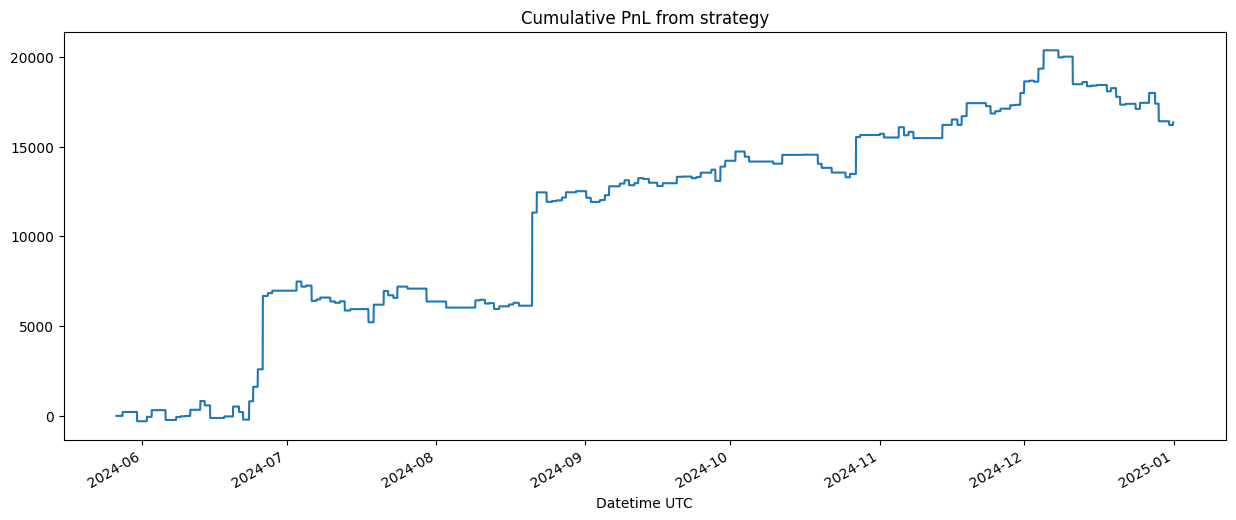

In [1]:
import pandas as pd
import numpy as np

# Import data from csv
output_df = pd.read_csv(
    r"C:\Users\franc\Desktop\Courses\Job applications\Tibber\limit_order_algo\src\data\optimized_charging_schedule.csv",
    parse_dates=["Datetime UTC"],
)
output_df.set_index("Datetime UTC", inplace=True)
output_df.head()

# Calculate PnL based on whether the algorithm decided to buy at spot or imbalance price
mask = output_df["optimal_plan"] > 0
output_df.loc[mask, "pnl_eur"] = np.where(
    output_df.loc[mask, "expected_cost_eur"] <= output_df.loc[mask, "spot_eur"],
    # If expected cost < spot, we save by buying at imbalance
    (output_df.loc[mask, "spot_eur"] - output_df.loc[mask, "imb_eur"])
    * output_df.loc[mask, "optimal_plan"]
    / 1000,
    # Otherwise, we would have saved by buying at spot
    (output_df.loc[mask, "imb_eur"] - output_df.loc[mask, "spot_eur"])
    * output_df.loc[mask, "optimal_plan"]
    / 1000,
)

output_df["pnl_eur"] = output_df["pnl_eur"].fillna(0)
output_df["pnl_eur"].cumsum().plot(
    title="Cumulative PnL from strategy", figsize=(15, 6)
)
print("Final PnL: €{:.2f}".format(output_df["pnl_eur"].sum()))

In the last semester of 2024, the algorithm would have had a profit of ~€16,353. This is not too impressive, but considering the limitations in the development of the algorithm its not too bad. There are multiple ways in which the performance can be optimized as will be discussed in the slides deck.

Now let's test how it would have performed in the day for which I was provided with day-ahead spot prices and the estimates of the coming days. Based on matching the prices, I identified these date as 10th till 12th of April 2024. Let's run the auction optimization for that charging session. Unfortunately, I did not know when building the models and used these dates as well for the training, which means that the test would not be completely fair. For illustration, I will conduct it anyway.

In [2]:
import logging
from pathlib import Path

# Define notebook logger
logger = logging.getLogger("notebook")
logger.setLevel(logging.INFO)
handler = logging.StreamHandler()
formatter = logging.Formatter("%(asctime)s - %(name)s - %(levelname)s - %(message)s")
handler.setFormatter(formatter)
logger.addHandler(handler)

# Import custom modules here to avoid circular imports and logger mislabeling
from auction_optimization_helpers import (
    load_data_limit_price_prediction,
    load_models,
    load_demand_simulation_data,
    prepare_data_for_optimization,
    optimize_charging_schedule,
)

data_dir = Path("./src/data")

# Step 1: Load data for limit price predictions
logger.info("Step 1: Loading data for limit price prediction models.")
(
    X_train_scaled,
    X_test_scaled,
    y1_train,
    y1_test,
    y2_train_scaled,
    y2_train,
    y2_scaler,
    full_data_df,
) = load_data_limit_price_prediction(str(data_dir), final_test=True)

# Step 2: Load limit price models
logger.info("Step 2: Loading machine learning models.")
clf_model, reg_model = load_models()
if clf_model is None or reg_model is None:
    logger.error("Failed to load one or both models. Exiting.")

# Step 3: Load the simulated data
logger.info("Step 3: Loading demand simulation data.")
v_max_df, total_demand = load_demand_simulation_data(data_dir)
logger.info("Loaded total demand: %.2f kWh", total_demand)

# Step 4: Prepare data for optimization
logger.info("Step 4: Preparing data for optimization.")
output_df = prepare_data_for_optimization(
    clf_model, reg_model, X_train_scaled, y2_train, y2_scaler, full_data_df, v_max_df
)
if output_df is None:
    logger.error("Data preparation failed. Exiting.")

# Step 4a: For testing, trim the output_df to the dates of interest
start_date = "2024-04-10"
end_date = "2024-04-12"
mask = (output_df.index >= start_date) & (output_df.index <= end_date)
output_df = output_df.loc[mask]

# Step 5: Run the optimization with the loaded total_demand
logger.info("Step 5: Running optimization to find the optimal charging schedule.")
optimized_df = optimize_charging_schedule(
    output_df,
    total_energy_demand=total_demand,
    cost_col="expected_cost_eur",
    vmax_col="v_max",
)
output_df = optimized_df.copy()

2025-09-25 13:26:46,287 - notebook - INFO - Step 1: Loading data for limit price prediction models.


2025-09-25 13:26:46,287 - notebook - INFO - Step 1: Loading data for limit price prediction models.
2025-09-25 13:26:46,288 - auction_optimization_helpers - INFO - --> Loading full data from directory: src\data
2025-09-25 13:26:46,290 - data_prep - INFO - Starting limit_price_data_prep function.
2025-09-25 13:26:46,291 - data_prep - INFO - --> Extracting and joining raw data from sources...
2025-09-25 13:26:46,291 - data_prep - INFO - Starting get_generation_data function
2025-09-25 13:26:46,462 - data_prep - INFO - Completed get_generation_data. Final shape: (17568, 5)
2025-09-25 13:26:46,463 - data_prep - INFO - Starting get_consumption_data function
2025-09-25 13:26:46,557 - data_prep - INFO - Completed get_consumption_data. Final shape: (17566, 1)
2025-09-25 13:26:46,557 - data_prep - INFO - Starting get_weather_data function
2025-09-25 13:26:46,616 - data_prep - INFO - Completed get_weather_data. Final shape: (17544, 2)
2025-09-25 13:26:46,623 - data_prep - INFO - Combined datafra

2025-09-25 13:26:52,162 - notebook - INFO - Step 2: Loading machine learning models.


2025-09-25 13:26:52,162 - notebook - INFO - Step 2: Loading machine learning models.
2025-09-25 13:26:52,217 - auction_optimization_helpers - INFO - --> Models loaded successfully.


2025-09-25 13:26:52,218 - notebook - INFO - Step 3: Loading demand simulation data.


2025-09-25 13:26:52,218 - notebook - INFO - Step 3: Loading demand simulation data.
2025-09-25 13:26:52,220 - auction_optimization_helpers - INFO - --> Loading v_max from src\data\v_max.csv
2025-09-25 13:26:52,224 - auction_optimization_helpers - INFO - --> Loading total demand from src\data\total_demand.csv
2025-09-25 13:26:52,233 - auction_optimization_helpers - INFO - ----> Demand simulation data loaded successfully.


2025-09-25 13:26:52,233 - notebook - INFO - Loaded total demand: 34741.00 kWh


2025-09-25 13:26:52,233 - notebook - INFO - Loaded total demand: 34741.00 kWh


2025-09-25 13:26:52,236 - notebook - INFO - Step 4: Preparing data for optimization.


2025-09-25 13:26:52,236 - notebook - INFO - Step 4: Preparing data for optimization.
2025-09-25 13:26:52,237 - auction_optimization_helpers - INFO - ----> Generating predictions from models.
2025-09-25 13:26:54,159 - auction_optimization_helpers - INFO - ------> Predictions generated successfully.
2025-09-25 13:26:54,161 - auction_optimization_helpers - INFO - ----> Merging with relevant columns from full dataset.
2025-09-25 13:26:54,182 - auction_optimization_helpers - INFO - ------> Data preparation for optimization completed.


2025-09-25 13:26:54,185 - notebook - INFO - Step 5: Running optimization to find the optimal charging schedule.


2025-09-25 13:26:54,185 - notebook - INFO - Step 5: Running optimization to find the optimal charging schedule.
2025-09-25 13:26:54,186 - auction_optimization_helpers - INFO - --> Starting optimization of charging schedule.
2025-09-25 13:26:54,193 - auction_optimization_helpers - INFO - ----> Optimization successful for night session starting on 2024-04-10.
2025-09-25 13:26:54,197 - auction_optimization_helpers - INFO - ----> Optimization successful for night session starting on 2024-04-11.


Final PnL: €0.00


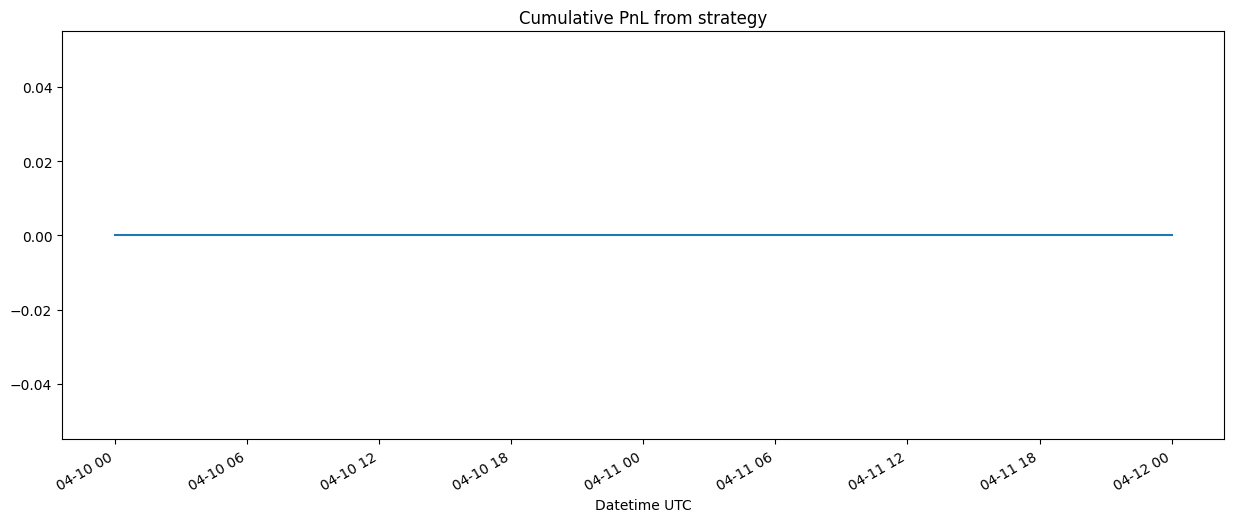

In [3]:
# Calculate PnL based on whether the algorithm decided to buy at spot or imbalance price
mask = output_df["optimal_plan"] > 0
output_df.loc[mask, "pnl_eur"] = np.where(
    output_df.loc[mask, "expected_cost_eur"] <= output_df.loc[mask, "spot_eur"],
    # If expected cost < spot, we save by buying at imbalance
    (output_df.loc[mask, "spot_eur"] - output_df.loc[mask, "imb_eur"])
    * output_df.loc[mask, "optimal_plan"]
    / 1000,
    # Otherwise, we would have saved by buying at spot
    (output_df.loc[mask, "imb_eur"] - output_df.loc[mask, "spot_eur"])
    * output_df.loc[mask, "optimal_plan"]
    / 1000,
)

output_df["pnl_eur"] = output_df["pnl_eur"].fillna(0)
output_df["pnl_eur"].cumsum().plot(
    title="Cumulative PnL from strategy", figsize=(15, 6)
)
print("Final PnL: €{:.2f}".format(output_df["pnl_eur"].sum()))

Interestingly, the algorithm wouldn't have had any added value that specific day. When analysing why, it becomes evident that the optimal plan during those days charged the EV fleet at hours where the day ahead spot price and imbalance price were equal.

In [4]:
output_df[output_df["optimal_plan"] > 0][
    ["spot_eur", "imb_eur", "v_max", "optimal_plan", "pnl_eur"]
]

,spot_eur,imb_eur,v_max,optimal_plan,pnl_eur
Datetime UTC,,,,,
2024-04-11 00:00:00+00:00,-3.06,-3.06,34741.0,34741.0,0.0
2024-04-11 22:00:00+00:00,4.16,4.16,34741.0,34741.0,0.0


This brings me to the end of my assignment. I look forward to hearing your thoughts!